<a href="https://colab.research.google.com/github/AmirHoseinTaherkhani/Python/blob/main/Kaggle/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Adding our json file from Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirhoseintaherkhani","key":"7d71f0abc665e83ecff23785ec145fd8"}'}

In [ ]:
#shell command
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c Titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.71MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 29.2MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 59.8MB/s]


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
def duplicate_finder(df):
    '''
    check for duplicates and remove if there was any
    '''
    df.drop_duplicates(subset=None, keep= 'first', inplace=True)
    return df

In [ ]:
def null_handler1(df):
    '''
    check for columns with more than 50% null value
    '''
    for column in df.columns:
        if df[df[column].isnull()]['PassengerId'].count()/df['PassengerId'].count() > .5:
            df.drop(column, axis = 1, inplace = True)
    return df


In [ ]:
df_train = duplicate_finder(df_train)
df_test = duplicate_finder(df_test)
df_train = null_handler1(df_train)
df_test = null_handler1(df_test)

In [ ]:
def categorical_handler(df):
    '''
    This function turn categorical features to numerical ones.
    '''
    cat = df[df.select_dtypes(include = ["object"]).columns]
    num = df[df.select_dtypes(exclude = ["object"]).columns]
    dummy = pd.get_dummies(cat, drop_first= True)
    
    df2 = pd.concat([dummy,num], axis=1)
    return df2

In [ ]:
def categorical_remover(df):
    return df[df.select_dtypes(exclude = ["object"]).columns]

In [ ]:
#Using scikit learn library, we predict null values for the remainding featuers. 
#This method is also called multivariate imputation.

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")

age_train = imputer.fit_transform(df_train['Age'].values.reshape((-1,1)))
age_test = imputer.transform(df_test['Age'].values.reshape((-1,1)))

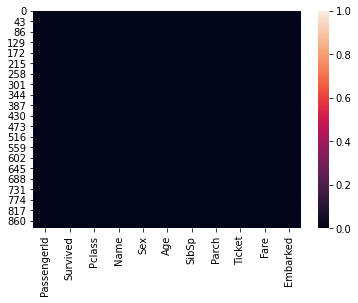

In [ ]:
df_train['Age'] = age_train
sns.heatmap(df_train.isnull())

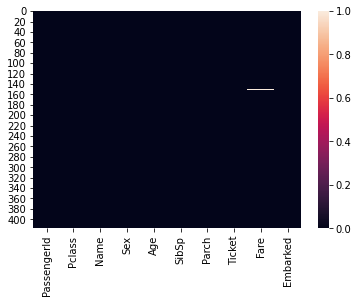

In [ ]:
df_test['Age'] = age_test
sns.heatmap(df_test.isnull())

In [ ]:
#handling one null in the test set
df_test['Fare'].fillna(value = df_test['Fare'].mean(), inplace = True)

In [ ]:
#we choose the features that might be related to survival. For example, name is not relevant.
X = df_train[['Pclass','Sex', 'Age', 'Parch','Fare', 'Embarked']]
y = df_train['Survived']
df_test = df_test[['Pclass','Sex', 'Age', 'Parch','Fare', 'Embarked']]

In [ ]:
#now we handle the categorical features
X = categorical_handler(X)
df_test = categorical_handler(df_test)

X = categorical_remover(X)
df_test = categorical_remover(df_test)

In [ ]:
#Scale our features
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X)
X = scalar.transform(X)
df_test = scalar.transform(df_test)

In [ ]:
#we want to develop a deep learning model for this classification problem
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(units = 7, activation= tf.nn.relu, input_shape = (7,)),
                    tf.keras.layers.Dense(units = 16, activation= tf.nn.relu),
                    tf.keras.layers.Dense(units = 32, activation= tf.nn.relu),
                    tf.keras.layers.Dense(units = 16, activation= tf.nn.relu),
                    tf.keras.layers.Dense(units = 8, activation= tf.nn.relu),
                    tf.keras.layers.Dense(units = 1 , activation= tf.nn.relu),
                    tf.keras.layers.Dense(units = 1 , activation= tf.nn.sigmoid)                 
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_26 (Dense)             (None, 16)                128       
_________________________________________________________________
dense_27 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [ ]:
model.compile(loss= 'binary_crossentropy',
              optimizer = 'adam',
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs = 500)

Epoch 1/500
23/23 [==============================] - 1s 2ms/step - loss: 0.6711 - accuracy: 0.6152
Epoch 2/500
23/23 [==============================] - 0s 2ms/step - loss: 0.6246 - accuracy: 0.6152
Epoch 3/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5773 - accuracy: 0.6152
Epoch 4/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5494 - accuracy: 0.6152
Epoch 5/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.6152
Epoch 6/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7809
Epoch 7/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7921
Epoch 8/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.8048
Epoch 9/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5181 - accuracy: 0.8090
Epoch 10/500
23/23 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.8006
Epoch 11/

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred = np.around(pred)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_test, pred)

0.19553072625698323

In [ ]:
outcome = model.predict(df_test)

In [ ]:
outcome = np.around(outcome)

In [ ]:
outcome[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [ ]:
finalized = pd.read_csv('/content/test.csv')

In [ ]:
finalized.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
outcome.shape

(418, 1)

In [ ]:
len(finalized)

418

In [ ]:
df = pd.concat([finalized['PassengerId'],pd.DataFrame(outcome,columns=['Survived'])], axis = 1)

In [ ]:
df.set_index('PassengerId', inplace= True)

In [ ]:
df.to_csv('submission.csv')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>